In [2]:
# read data

from mnist import MNIST
import numpy as np
mndata = MNIST("/Users/jigyayadav/Desktop/Codes/neuralnets253/HW1")
mndata.gz = True
images, labels = mndata.load_training() #Images is a list of 60000 images of 784 dimensions, Labels is a list of 60000 ints
imagesTest, labelsTest = mndata.load_testing()

images = np.array(images)
labels = np.array(labels)
imagesTest = np.array(imagesTest)
labelsTest = np.array(labelsTest)

images_train = images[:200]
images_test = imagesTest[-50:]
labels_train = labels[:200]
labels_test = labelsTest[-50:]
images_train = np.array(images_train)
labels_train = np.array(labels_train)
images_test = np.array(images_test)
labels_test = np.array(labels_test)

# Normalization
images_train = images_train*(1/127.5)
images_test = images_test*(1/127.5)
images_train = images_train-arrOnes
arrOnes = np.ones_like(images_test)
images_test = images_test-arrOnes

# Should this be appended after or before normalization
images_train = np.insert(images_train, 0, 1, axis=1)
images_test = np.insert(images_test, 0, 1, axis=1)

numFeatures = len(images[0, :])

# Divide between validation and training
from sklearn.model_selection import train_test_split
images_train, images_validation, labels_train, labels_validation = train_test_split(images_train, labels_train, test_size=0.10)

In [4]:
labelNums = 10

def labelsToVectForm(labels):
    vectForm = np.zeros((len(labels), labelNums))
    for i in range(len(labels)):
        vectForm[i][labels[i]] = 1
    return vectForm

labels_train = labelsToVectForm(labels_train)
labels_test = labelsToVectForm(labels_test)
labels_validation = labelsToVectForm(labels_validation)

In [17]:
labels_validation.shape

(20, 10)

In [25]:
import math

# Calculate things going forward
from sklearn.metrics import accuracy_score

numInputLayers = 784
numHiddenLayers = 64
numOutputLayers = 10
numExamples = 100

# X is (n*i) and weights is (i*j)
# returns (n*j) vector
def calculateWeightedInput(weights, x):
    return (x.dot(weights))

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def softmaxFunc(prod):
#     for i in range(len(prod)):
#         for j in range(len(prod[i, :])):
#             prod[i][j] = math.exp(prod[i][j])
    prod = np.exp(prod)
    for i in range(len(prod)):
        rowSum = sum(prod[i, :])
        for j in range(len(prod[i, :])):
            prod[i][j] = prod[i][j]/rowSum    
    return prod

# X is (n*i) and weights is (i*j)
# returns (n*j) vector
def sigmoidActivation(weights, x):
    print("In sigmoid activation")
    print(weights.shape)
    print(x.shape)
    prod = calculateWeightedInput(weights, x)
    for i in range(len(prod)):
        for j in range(len(prod[i, :])):
            prod[i][j] = sigmoid(prod[i][j])
    return prod

# X is (n*i) and weights is (i*j)
# returns (n*j) vector
def softmaxActivation(weights, x):
    prod = calculateWeightedInput(weights, x)
    prod = softmaxFunc(prod)
    return prod

# X is (n*i) and weights is (i*j)
# returns (n*j) vector
def YHotEncoding(a):
    b = np.zeros_like(a)
    b[np.arange(len(a)), a.argmax(1)] = 1
    return b

def calculateOutputPerLayer(weights, x):
    outputHiddenLayer = sigmoidActivation(weights[0], x)
    inputSecondLayer = np.insert(outputHiddenLayer, 0, 1, axis=1)
    outputFinalLayer = softmaxActivation(weights[1], inputSecondLayer)
#     outputFinalLayer = findYHotEncoding(outputFinalLayer)
    return [outputHiddenLayer, outputFinalLayer]

# Calculate the derivative of the cost function wrt hidden to output layer weights
def delEWjk(x, y, t, z):
    differencePredictedActual = (y-t)
    # differentiation is j*k array
    differentiation = z.T.dot(differencePredictedActual)
    differentiation = differentiation*(1/len(x))
    return differentiation

# Calculate the derivative of the cost function wrt input to hidden layer weights
def delEWij(x, y, t, g, weights):
    differencePredictedActual = (y-t)
    # summation_k is n*j
    summation_k = (differencePredictedActual.dot(weights.T))
    # calculate g(a_j)*(1-g(a_j))- n*j
    # g_differentiation is (n*j)
    g_differentiation = np.multiply(g, np.ones_like(g)-g)
    prod1 = np.multiply(g_differentiation, summation_k)
    prod2 = x.T.dot(prod1)
    prod2 = prod2*(1/len(x))
    return prod2

# x is n*i vector
# weights is j*k vector
# y and t are (n*k) vector
# z is (n*j) vector
def updateWeightsHiddenToOutput(weights, x, y, t, z, learningRate):
    derivativeE = delEWjk(x, y, t, z)
    updatedWeights = weights - learningRate*derivativeE
    return updatedWeights

# x is (n*i) vector
# y, t is (n*k)
# g is (n*j) vector
# weights is (j*k)
def updateWeightsInputToHidden(weights, x, y, t, g, learningRate):
    derivativeE = delEWij(x, y, t, g, weights)
    updatedWeights = weights - learningRate*derivativeE
    return updatedWeights

def costFunction(x, t, weights):
    sampLen = len(x)
    predProb = calculateOutputPerLayer(weights, x)[1]
#     vectorLabels = labelsToVectForm(t)
    cost = -1*(np.multiply(t, np.log(predProb)))/sampLen
    return [np.sum(cost), cost]

# Calculate derivate of nth example wrt weight_ij
def calculateApproximateDerivative(weights, epsilon, x, y, t, i, j, n, p):
    newWeights = weights
    newWeights[p][i][j] += epsilon
    costFunction1 = costFunction(x, t, newWeights)
    newWeights = weights
    newWeights[p][i][j] -= epsilon
    costFunction2 = costFunction(x, t, newWeights)
    approximateDerivative = (costFunction1[n]-costFunction2[n])/(2*epsilon)
    return approximateDerivative

def checkGradient(weights, epsilon, x, t):
    outputLayers = calculateOutputPerLayer(weights, x)
    y = outputLayers[1]
    
    # Check gradient input to hidden
    for n in range(0, 20000, 2000):
        print("For input to hidden layers")
        for i in range(0, 784, 200):
            for j in range(0, 64, 20):
                summation_k = 0
                for k in range(len(y[0, :])):
                    summation_k += weights[1][j][k]*(y[n][k]-t[n][k])
                actualDerivative = outputLayers[0][n][j]*(1-outputLayers[0][n][j])*x[n][i]*(summation_k)
                approximateDerivative = calculateApproximateDerivative(weights, epsilon, x, y, t, i, j, n, 0)
                diff = abs(actualDerivative-approximateDerivative)
                print("Difference between approximate gradient = ", diff, " ", abs(epsilon*epsilon-diff))
        
        print("For hidden to output layers")
        for j in range(0, 64, 20):
            for k in range(0, 10, 3):
                actualDerivative = outputLayers[0][n][j]*(y[n][k]-t[n][k])
                approximateDerivative = calculateApproximateDerivative(weights, epsilon, x, y, t, i, j, n, 1)
                diff = abs(actualDerivative-approximateDerivative)
                print("Difference between approximate gradient = ", diff, " ", abs(epsilon*epsilon-diff))

def calculateAccuracy(weights, x, t):
    predClass = calculateOutputPerLayer(weights, x)[1]
    predClass = YHotEncoding(predClass)
    return accuracy_score(t, predClass)

def gradientUpdateSingleUpdate(weights, x, t, learningRate):
    outputLayers = calculateOutputPerLayer(weights, x)
    inputSecondLayer = np.insert(outputLayers[0], 0, 1, axis=1)
    updateWtsHiddenToOutput = updateWeightsHiddenToOutput(weights[1], x, outputLayers[1], t, inputSecondLayer, learningRate)
    updateWtsInputToHidden = updateWeightsInputToHidden(weights[0], x, outputLayers[1], t, outputLayers[0], learningRate)
    updatedWeights = [updateWtsInputToHidden, updateWtsHiddenToOutput]
    return updatedWeights

def gradientDescent(numItrs, weights, x, t, learningRate):
    for itr in range(numItrs):
        # Calculate error with the given weights
        currTrainingError = costFunction(x[0], t[0], weights)
        currValidationError = costFunction(x[1], t[1], weights)
        print("Current validation error = ", currValidationError)
        weights = gradientUpdateSingleUpdate(weights, x[0], t[0], learningRate)

checkGradient([weightsIJ, weightsJK], 0.001, images_train, labels_train)
weightsIJ = np.random.rand(785, 64)
weightsJK = np.random.rand(65, 10)
gradientDescent(1000, [weightsIJ, weightsJK], [images_train, images_validation], [labels_train, labels_validation], 0.001)



In sigmoid activation
(785, 64)
(180, 785)
For input to hidden layers
In sigmoid activation
(785, 64)
(180, 785)
In sigmoid activation
(785, 64)
(180, 785)


IndexError: invalid index to scalar variable.

In [2]:
# read data

from mnist import MNIST
import numpy as np
mndata = MNIST("/Users/jigyayadav/Desktop/Codes/neuralnets253/HW1")
mndata.gz = True
images, labels = mndata.load_training() #Images is a list of 60000 images of 784 dimensions, Labels is a list of 60000 ints
imagesTest, labelsTest = mndata.load_testing()

images = np.array(images)
labels = np.array(labels)
imagesTest = np.array(imagesTest)
labelsTest = np.array(labelsTest)

images_train = images
images_test = imagesTest
labels_train = labels
labels_test = labelsTest
images_train = np.array(images_train)
labels_train = np.array(labels_train)
images_test = np.array(images_test)
labels_test = np.array(labels_test)

# Normalization
images_train = images_train*(1/127.5)
images_test = images_test*(1/127.5)
images_train = images_train-1.0
images_test = images_test-1.0

# Should this be appended after or before normalization
images_train = np.insert(images_train, 0, 1, axis=1)
images_test = np.insert(images_test, 0, 1, axis=1)

numFeatures = len(images[0, :])

# Divide between validation and training
from sklearn.model_selection import train_test_split
images_train, images_validation, labels_train, labels_validation = train_test_split(images_train, labels_train, test_size=0.10, random_state=42)

labelNums = 10

def labelsToVectForm(labels):
    vectForm = np.zeros((len(labels), labelNums))
    for i in range(len(labels)):
        vectForm[i][labels[i]] = 1
    return vectForm

t_train = labelsToVectForm(labels_train)
t_test = labelsToVectForm(labels_test)
t_validation = labelsToVectForm(labels_validation)

In [36]:
# Final implementation with learning rate =

from sklearn.metrics import accuracy_score
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Forward propagation

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# def softmaxFunc(prod):
#     prod = np.exp(prod)
#     for i in range(len(prod)):
#         rowSum = sum(prod[i, :])
#         for j in range(len(prod[i, :])):
#             prod[i][j] = prod[i][j]/rowSum    
#     return prod

def getPredClass(y):
    predClass = np.argmax(y, axis=1)
    return predClass

def calculateOutput(x, W1, W2):
    A1 = x.dot(W1)
    Z1 = sigmoid(A1)
    X2 = np.insert(Z1, 0, 1, axis=1)
    A2 = X2.dot(W2)
    Y = np.exp(A2)/np.sum(np.exp(A2), axis=1, keepdims = True)
    return Y

def calculateCost(x, t, W1, W2):
    Y = calculateOutput(x, W1, W2)
    cost = -(1/len(x))*(np.sum(np.multiply(t, np.log(Y))))
    return cost

def calculateCostOneInstance(x, t, W1, W2, n):
    Y = calculateOutput(x, W1, W2)
    cost = (-1/len(x))*(np.multiply(t, np.log(Y)))
    return np.sum(cost[n, :])

def calculateAccuracy(x, labels, W1, W2):
    Y = calculateOutput(x, W1, W2)
    predClass = getPredClass(Y)
    return accuracy_score(labels, predClass)

numHiddenLayers = 64
numInputLayers = 785
numOutputLayers = 10
batch_size = 128
batches = images_train.shape[0]//batch_size

def gradientDescent(initialLearningRate, shuffleData, useMomentum, alpha, randomWeights, useSigmoid):
    global images_train, t_train, labels_train
    trainingAcc = []
    validationAcc = []
    testAcc = []
    trainingErr = []
    validationErr = []
    testErr = []
    if (useMomentum):
        v1 = np.zeros(shape=(numInputLayers, numHiddenLayers))
        v2 = np.zeros(shape=(numHiddenLayers+1, numOutputLayers))
    if (randomWeights):
        W1 = np.random.uniform(low=-1.0, high=1.0, size=(785, 64))
        W2 = np.random.uniform(low=-1.0, high=1.0, size=(65, 10))
    else:
        W1 = np.random.normal(loc=0.0, scale=1/math.sqrt(785), size=(785, 64))
        W2 = np.random.normal(loc=0.0, scale=1/math.sqrt(65), size=(65, 10))
        
    prevValidationError = float('inf')
    minValidationError = float('inf')
    W1MinError = np.zeros(shape=(numInputLayers, numHiddenLayers))
    W2MinError = np.zeros(shape=(numHiddenLayers+1, numOutputLayers))
    cnt = 0
    epochMinWeight = 0
    stoppingIteration = 0
    for epoch in range(5000):
        learningRate = initialLearningRate/(1+epoch/2000)
        print("Epoch = ", epoch, " ", learningRate)
        if (shuffleData):
            images_train, t_train, labels_train = shuffle(images_train, t_train, labels_train)
        for b in range(batches):
            x = images_train[b*batch_size:(b+1)*batch_size]
            t = t_train[b*batch_size:(b+1)*batch_size]
            A1 = x.dot(W1)
            if (useSigmoid):
                Z1 = sigmoid(A1)
            else:
                Z1 = 1.7159*np.tanh((2/3)*A1)

            X2 = np.insert(Z1, 0, 1, axis=1)
            A2 = X2.dot(W2)
            Y = np.exp(A2)/np.sum(np.exp(A2), axis=1, keepdims = True)

            # Backward propagation
            W2_nobias = np.delete(W2, (0), axis=0)
            summation_k = (Y-t).dot(W2_nobias.T)
            if (useSigmoid):
                g_derivative = Z1*(1-Z1)
            else:
                g_derivative = 0.67*1.7159*(1-np.square(np.tanh((2/3)*A1)))
            delE_Wij = x.T.dot(np.multiply(summation_k, g_derivative))
            
            delE_Wij = delE_Wij/len(x)
            delE_Wjk = (X2.T.dot(Y-t))/len(x)
            if (useMomentum):
                v1 = alpha*v1 - learningRate*delE_Wij
                v2 = alpha*v2 - learningRate*delE_Wjk
                delW1 = v1
                delW2 = v2
            else:
                delW1 = -1*learningRate*delE_Wij
                delW2 = -1*learningRate*delE_Wjk
            W2 = W2+delW2
            W1 = W1+delW1

        currTrainingError = calculateCost(images_train, t_train, W1, W2)
        currvalidationError = calculateCost(images_validation, t_validation, W1, W2)
        currTestError = calculateCost(images_test, t_test, W1, W2)
        currTrainingAccuracy = calculateAccuracy(images_train, labels_train, W1, W2)
        currValidationAccuracy = calculateAccuracy(images_validation, labels_validation, W1, W2)
        currTestAccuracy = calculateAccuracy(images_test, labels_test, W1, W2)
        if (currvalidationError < minValidationError):
            W1MinError = W1
            W2MinError = W2
            epochMinWeight = epoch
            minValidationError = currvalidationError

        # Early stopping
        if (currvalidationError > prevValidationError):
                cnt += 1
                if (cnt >= 3):
                    stoppingIteration = epoch
                    break
        else:
            cnt = 0
        prevValidationError = currvalidationError
        
        trainingErr.append(currTrainingError)
        validationErr.append(currvalidationError)
        testErr.append(currTestError)
        trainingAcc.append(currTrainingAccuracy)
        validationAcc.append(currValidationAccuracy)
        testAcc.append(currTestAccuracy)
        
    # Plot all errors and accuracies
    plt.figure(1)
    plt.subplot(211)
    plt.plot(trainingErr, label='Train', color='blue')
    plt.plot(validationErr, label='Validation', color='green')
    plt.plot(testErr, label='Test', color='red')
    plt.ylabel('Loss function')
    plt.xlabel('Iterations')
    plt.legend()

    plt.subplot(212)
    plt.plot(trainingAcc, label='Train', color='blue')
    plt.plot(validationAcc, label='Validation', color='green')
    plt.plot(testAcc, label='Test', color='red')
    plt.ylabel('Accuracy')
    plt.xlabel('Iterations')
    plt.legend()
    plt.show()
    
    finalTestAccuracy = calculateAccuracy(images_test, labels_test, W1MinError, W2MinError)
    finalTrainingAccuracy = calculateAccuracy(images_train, labels_train, W1MinError, W2MinError)
    finalValidationAccuracy = calculateAccuracy(images_validation, labels_validation, W1MinError, W2MinError)
    print("Final training accuracy = ", finalTrainingAccuracy)
    print("Final validation accuracy = ", finalValidationAccuracy)
    print("Final test accuracy = ", finalTestAccuracy)
        
    return [trainingErr, validationErr, testErr, trainingAcc, validationAcc, testAcc]

Epoch =  0   0.1
Epoch =  1   0.09995002498750626
Epoch =  2   0.09990009990009992
Epoch =  3   0.09985022466300549
Epoch =  4   0.0998003992015968
Epoch =  5   0.09975062344139651
Epoch =  6   0.09970089730807578
Epoch =  7   0.09965122072745392
Epoch =  8   0.09960159362549802
Epoch =  9   0.09955201592832257
Epoch =  10   0.09950248756218907
Epoch =  11   0.09945300845350571
Epoch =  12   0.09940357852882704
Epoch =  13   0.09935419771485346
Epoch =  14   0.099304865938431
Epoch =  15   0.09925558312655086
Epoch =  16   0.09920634920634921
Epoch =  17   0.09915716410510661
Epoch =  18   0.09910802775024778
Epoch =  19   0.09905894006934125
Epoch =  20   0.09900990099009901
Epoch =  21   0.09896091044037607
Epoch =  22   0.09891196834817015
Epoch =  23   0.09886307464162135
Epoch =  24   0.09881422924901186
Epoch =  25   0.09876543209876544
Epoch =  26   0.0987166831194472
Epoch =  27   0.0986679822397632
Epoch =  28   0.09861932938856016
Epoch =  29   0.09857072449482504
Epoch =  30

Epoch =  239   0.08932559178204556
Epoch =  240   0.08928571428571429
Epoch =  241   0.0892458723784025
Epoch =  242   0.08920606601248886
Epoch =  243   0.08916629514043692
Epoch =  244   0.08912655971479502
Epoch =  245   0.08908685968819599
Epoch =  246   0.08904719501335709
Epoch =  247   0.08900756564307967
Epoch =  248   0.0889679715302491
Epoch =  249   0.08892841262783459
Epoch =  250   0.08888888888888889
Epoch =  251   0.08884940026654821
Epoch =  252   0.08880994671403199
Epoch =  253   0.0887705281846427
Epoch =  254   0.08873114463176575
Epoch =  255   0.08869179600886919
Epoch =  256   0.08865248226950354
Epoch =  257   0.08861320336730173
Epoch =  258   0.08857395925597875
Epoch =  259   0.08853474988933158
Epoch =  260   0.08849557522123895
Epoch =  261   0.08845643520566121


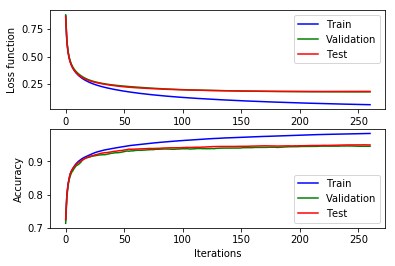

Final training accuracy =  0.9841111111111112
Final validation accuracy =  0.9456666666666667
Final test accuracy =  0.9499


In [18]:
result = gradientDescent(0.1, False, False, 0.0, True, False)

In [25]:
result[2][-1]

0.18329987024624073

Epoch =  0   0.1
Epoch =  1   0.09995002498750626
Epoch =  2   0.09990009990009992
Epoch =  3   0.09985022466300549
Epoch =  4   0.0998003992015968
Epoch =  5   0.09975062344139651
Epoch =  6   0.09970089730807578
Epoch =  7   0.09965122072745392
Epoch =  8   0.09960159362549802
Epoch =  9   0.09955201592832257
Epoch =  10   0.09950248756218907
Epoch =  11   0.09945300845350571
Epoch =  12   0.09940357852882704
Epoch =  13   0.09935419771485346
Epoch =  14   0.099304865938431
Epoch =  15   0.09925558312655086
Epoch =  16   0.09920634920634921
Epoch =  17   0.09915716410510661
Epoch =  18   0.09910802775024778
Epoch =  19   0.09905894006934125
Epoch =  20   0.09900990099009901
Epoch =  21   0.09896091044037607
Epoch =  22   0.09891196834817015
Epoch =  23   0.09886307464162135
Epoch =  24   0.09881422924901186
Epoch =  25   0.09876543209876544
Epoch =  26   0.0987166831194472
Epoch =  27   0.0986679822397632
Epoch =  28   0.09861932938856016
Epoch =  29   0.09857072449482504
Epoch =  30

Epoch =  239   0.08932559178204556
Epoch =  240   0.08928571428571429
Epoch =  241   0.0892458723784025
Epoch =  242   0.08920606601248886
Epoch =  243   0.08916629514043692
Epoch =  244   0.08912655971479502
Epoch =  245   0.08908685968819599
Epoch =  246   0.08904719501335709
Epoch =  247   0.08900756564307967
Epoch =  248   0.0889679715302491
Epoch =  249   0.08892841262783459
Epoch =  250   0.08888888888888889
Epoch =  251   0.08884940026654821
Epoch =  252   0.08880994671403199
Epoch =  253   0.0887705281846427
Epoch =  254   0.08873114463176575
Epoch =  255   0.08869179600886919
Epoch =  256   0.08865248226950354
Epoch =  257   0.08861320336730173
Epoch =  258   0.08857395925597875
Epoch =  259   0.08853474988933158
Epoch =  260   0.08849557522123895
Epoch =  261   0.08845643520566121
Epoch =  262   0.08841732979664015
Epoch =  263   0.08837825894829873
Epoch =  264   0.08833922261484098
Epoch =  265   0.08830022075055188
Epoch =  266   0.088261253309797
Epoch =  267   0.08822232

Epoch =  475   0.08080808080808081
Epoch =  476   0.08077544426494346
Epoch =  477   0.08074283407347599
Epoch =  478   0.08071025020177564
Epoch =  479   0.08067769261799113
Epoch =  480   0.08064516129032259
Epoch =  481   0.08061265618702138
Epoch =  482   0.08058017727639001
Epoch =  483   0.08054772452678212
Epoch =  484   0.08051529790660227
Epoch =  485   0.08048289738430585
Epoch =  486   0.08045052292839905
Epoch =  487   0.08041817450743868
Epoch =  488   0.08038585209003216
Epoch =  489   0.08035355564483729
Epoch =  490   0.08032128514056225
Epoch =  491   0.08028904054596547
Epoch =  492   0.08025682182985554
Epoch =  493   0.08022462896109106
Epoch =  494   0.0801924619085806
Epoch =  495   0.08016032064128256
Epoch =  496   0.08012820512820513
Epoch =  497   0.08009611533840609
Epoch =  498   0.08006405124099279
Epoch =  499   0.08003201280512205
Epoch =  500   0.08
Epoch =  501   0.07996801279488205
Epoch =  502   0.07993605115907275
Epoch =  503   0.07990411506192568
E

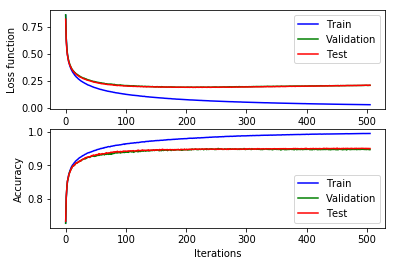

Final training accuracy =  0.9801296296296297
Final validation accuracy =  0.9473333333333334
Final test accuracy =  0.9471


In [26]:
# With shuffling

result = gradientDescent(0.1, True, False, 0.0, True, False)

In [27]:
# With sigmoid

result = gradientDescent(0.1, True, False, 0.0, True, True)

0.2088257025138795

Epoch =  0   0.1
Epoch =  1   0.09995002498750626
Epoch =  2   0.09990009990009992
Epoch =  3   0.09985022466300549
Epoch =  4   0.0998003992015968
Epoch =  5   0.09975062344139651
Epoch =  6   0.09970089730807578
Epoch =  7   0.09965122072745392
Epoch =  8   0.09960159362549802
Epoch =  9   0.09955201592832257
Epoch =  10   0.09950248756218907
Epoch =  11   0.09945300845350571
Epoch =  12   0.09940357852882704
Epoch =  13   0.09935419771485346
Epoch =  14   0.099304865938431
Epoch =  15   0.09925558312655086
Epoch =  16   0.09920634920634921
Epoch =  17   0.09915716410510661
Epoch =  18   0.09910802775024778
Epoch =  19   0.09905894006934125
Epoch =  20   0.09900990099009901
Epoch =  21   0.09896091044037607
Epoch =  22   0.09891196834817015
Epoch =  23   0.09886307464162135
Epoch =  24   0.09881422924901186
Epoch =  25   0.09876543209876544
Epoch =  26   0.0987166831194472
Epoch =  27   0.0986679822397632
Epoch =  28   0.09861932938856016
Epoch =  29   0.09857072449482504
Epoch =  30

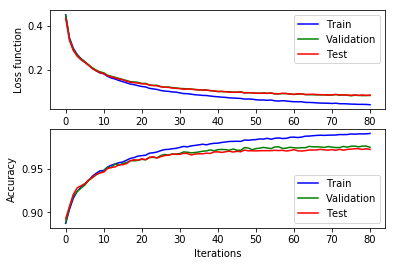

Final training accuracy =  0.9899259259259259
Final validation accuracy =  0.9758333333333333
Final test accuracy =  0.9726


In [33]:
# Normal initialization of weights

result = gradientDescent(0.1, True, False, 0.0, False, True)

Epoch =  0   0.1
Epoch =  1   0.09995002498750626
Epoch =  2   0.09990009990009992
Epoch =  3   0.09985022466300549
Epoch =  4   0.0998003992015968
Epoch =  5   0.09975062344139651
Epoch =  6   0.09970089730807578
Epoch =  7   0.09965122072745392
Epoch =  8   0.09960159362549802
Epoch =  9   0.09955201592832257
Epoch =  10   0.09950248756218907
Epoch =  11   0.09945300845350571
Epoch =  12   0.09940357852882704
Epoch =  13   0.09935419771485346
Epoch =  14   0.099304865938431
Epoch =  15   0.09925558312655086
Epoch =  16   0.09920634920634921
Epoch =  17   0.09915716410510661
Epoch =  18   0.09910802775024778
Epoch =  19   0.09905894006934125
Epoch =  20   0.09900990099009901
Epoch =  21   0.09896091044037607
Epoch =  22   0.09891196834817015
Epoch =  23   0.09886307464162135
Epoch =  24   0.09881422924901186
Epoch =  25   0.09876543209876544
Epoch =  26   0.0987166831194472
Epoch =  27   0.0986679822397632
Epoch =  28   0.09861932938856016
Epoch =  29   0.09857072449482504
Epoch =  30

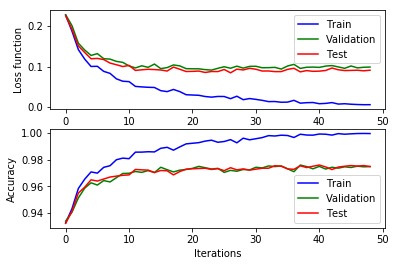

Final training accuracy =  0.9946296296296296
Final validation accuracy =  0.973
Final test accuracy =  0.9727


In [34]:
# With momentum

result = gradientDescent(0.1, True, True, 0.9, False, True)

Epoch =  0   0.1
Epoch =  1   0.09995002498750626
Epoch =  2   0.09990009990009992
Epoch =  3   0.09985022466300549
Epoch =  4   0.0998003992015968
Epoch =  5   0.09975062344139651
Epoch =  6   0.09970089730807578
Epoch =  7   0.09965122072745392
Epoch =  8   0.09960159362549802
Epoch =  9   0.09955201592832257
Epoch =  10   0.09950248756218907
Epoch =  11   0.09945300845350571
Epoch =  12   0.09940357852882704
Epoch =  13   0.09935419771485346
Epoch =  14   0.099304865938431
Epoch =  15   0.09925558312655086
Epoch =  16   0.09920634920634921
Epoch =  17   0.09915716410510661
Epoch =  18   0.09910802775024778
Epoch =  19   0.09905894006934125
Epoch =  20   0.09900990099009901
Epoch =  21   0.09896091044037607
Epoch =  22   0.09891196834817015
Epoch =  23   0.09886307464162135
Epoch =  24   0.09881422924901186
Epoch =  25   0.09876543209876544
Epoch =  26   0.0987166831194472
Epoch =  27   0.0986679822397632
Epoch =  28   0.09861932938856016
Epoch =  29   0.09857072449482504
Epoch =  30

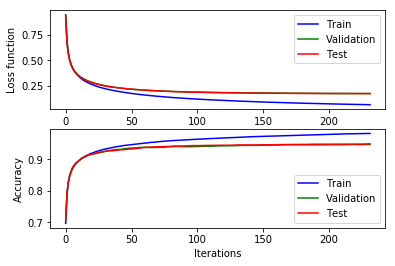

Final training accuracy =  0.9815185185185186
Final validation accuracy =  0.9466666666666667
Final test accuracy =  0.9487


In [38]:
result = gradientDescent(0.1, False, False, 0.0, True, True)

Epoch =  0   0.1
Epoch =  1   0.09995002498750626
Epoch =  2   0.09990009990009992
Epoch =  3   0.09985022466300549
Epoch =  4   0.0998003992015968
Epoch =  5   0.09975062344139651
Epoch =  6   0.09970089730807578
Epoch =  7   0.09965122072745392
Epoch =  8   0.09960159362549802
Epoch =  9   0.09955201592832257
Epoch =  10   0.09950248756218907
Epoch =  11   0.09945300845350571
Epoch =  12   0.09940357852882704
Epoch =  13   0.09935419771485346
Epoch =  14   0.099304865938431
Epoch =  15   0.09925558312655086
Epoch =  16   0.09920634920634921
Epoch =  17   0.09915716410510661
Epoch =  18   0.09910802775024778
Epoch =  19   0.09905894006934125
Epoch =  20   0.09900990099009901
Epoch =  21   0.09896091044037607
Epoch =  22   0.09891196834817015
Epoch =  23   0.09886307464162135
Epoch =  24   0.09881422924901186
Epoch =  25   0.09876543209876544
Epoch =  26   0.0987166831194472
Epoch =  27   0.0986679822397632
Epoch =  28   0.09861932938856016
Epoch =  29   0.09857072449482504
Epoch =  30

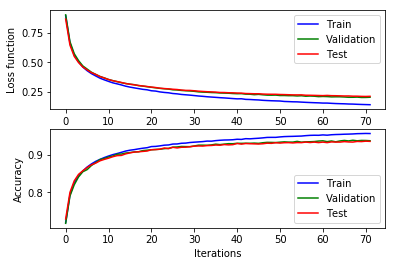

Final training accuracy =  0.9573518518518519
Final validation accuracy =  0.939
Final test accuracy =  0.9359


In [39]:
# With shuffling

result = gradientDescent(0.1, True, False, 0.0, True, True)

In [ ]:
# With sigmoid

result = gradientDescent(0.1, True, False, 0.0, True, False)

Epoch =  0   0.1
Epoch =  1   0.09995002498750626
Epoch =  2   0.09990009990009992
Epoch =  3   0.09985022466300549
Epoch =  4   0.0998003992015968
Epoch =  5   0.09975062344139651
Epoch =  6   0.09970089730807578
Epoch =  7   0.09965122072745392
Epoch =  8   0.09960159362549802
Epoch =  9   0.09955201592832257
Epoch =  10   0.09950248756218907
Epoch =  11   0.09945300845350571
Epoch =  12   0.09940357852882704
Epoch =  13   0.09935419771485346
Epoch =  14   0.099304865938431
Epoch =  15   0.09925558312655086
Epoch =  16   0.09920634920634921
Epoch =  17   0.09915716410510661
Epoch =  18   0.09910802775024778
Epoch =  19   0.09905894006934125
Epoch =  20   0.09900990099009901
Epoch =  21   0.09896091044037607
Epoch =  22   0.09891196834817015
Epoch =  23   0.09886307464162135
Epoch =  24   0.09881422924901186
Epoch =  25   0.09876543209876544
Epoch =  26   0.0987166831194472
Epoch =  27   0.0986679822397632
Epoch =  28   0.09861932938856016
Epoch =  29   0.09857072449482504
Epoch =  30

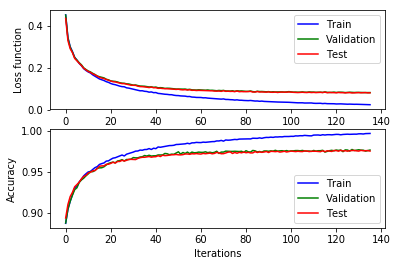

Final training accuracy =  0.9964259259259259
Final validation accuracy =  0.9751666666666666
Final test accuracy =  0.9757


In [40]:
# Normal initialization of weights

result = gradientDescent(0.1, True, False, 0.0, False, True)

Epoch =  0   0.1
Epoch =  1   0.09995002498750626
Epoch =  2   0.09990009990009992
Epoch =  3   0.09985022466300549
Epoch =  4   0.0998003992015968
Epoch =  5   0.09975062344139651
Epoch =  6   0.09970089730807578
Epoch =  7   0.09965122072745392
Epoch =  8   0.09960159362549802
Epoch =  9   0.09955201592832257
Epoch =  10   0.09950248756218907
Epoch =  11   0.09945300845350571
Epoch =  12   0.09940357852882704
Epoch =  13   0.09935419771485346
Epoch =  14   0.099304865938431
Epoch =  15   0.09925558312655086
Epoch =  16   0.09920634920634921
Epoch =  17   0.09915716410510661
Epoch =  18   0.09910802775024778
Epoch =  19   0.09905894006934125
Epoch =  20   0.09900990099009901
Epoch =  21   0.09896091044037607
Epoch =  22   0.09891196834817015
Epoch =  23   0.09886307464162135
Epoch =  24   0.09881422924901186
Epoch =  25   0.09876543209876544
Epoch =  26   0.0987166831194472
Epoch =  27   0.0986679822397632


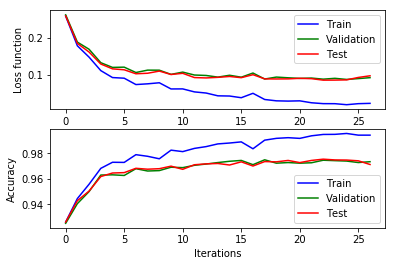

Final training accuracy =  0.9957407407407407
Final validation accuracy =  0.974
Final test accuracy =  0.9748


In [42]:
# With momentum

result = gradientDescent(0.1, True, True, 0.9, False, True)